In [2]:
import os
os.environ['R_HOME'] = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
os.environ["R_SESSION_TMPDIR"] = "/data1/lesliec/sneha/test/"
from rpy2.rinterface_lib import openrlib
openrlib.R_HOME = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
import scanpy as sc

In [4]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R
library(Matrix)
library(Seurat)
library(ArchR)
library(ggplot2)
#library(dplyr)
library(gridExtra)
library(viridis)

In [7]:
#adata = sc.read_h5ad("/data1/lesliec/sneha/workspace/CRC_analysis/outfiles/multiome_1_outs/multiome_rna_tTreg_clean.h5ad")
adata = sc.read_h5ad('./data/multiome_mouse_4wks_scrna.h5ad')
#adata.obs_names = [x.split('-')[-1] + '#' + '-'.join(x.split('-')[:2]) for x in adata.obs_names]

In [8]:
'''
adata.obs['celltype_label'] = adata.obs['celltype_label'].values.tolist()
adata.obs.loc[adata.obs['celltype_label']=='Helios+ Treg', 'celltype_label'] = 'IL10- Treg'
adata.obs.loc[adata.obs['celltype_label']=='Innate-like T#1', 'celltype_label'] = 'ILTCK #2'
adata.obs.loc[adata.obs['celltype_label']=='Innate-like T#2', 'celltype_label'] = 'ILTCK #1'
adata.obs.loc[adata.obs['celltype_label']=='Cytotoxic CD8', 'celltype_label'] = 'Effector CD8'
adata.obs.loc[adata.obs['celltype_label']=='PD1+ CD8', 'celltype_label'] = 'TD CD8'
adata.obs.loc[adata.obs['celltype_label']=='PD1+ CD4', 'celltype_label'] = 'PD1+ Th1'
adata.obs.loc[adata.obs['celltype_label']=='CCR7+ CD8', 'celltype_label'] = 'Memory CD8'
adata.obs.loc[adata.obs['celltype_label']=='CCR7+ CD4', 'celltype_label'] = 'Memory CD4'
adata.obs.loc[adata.obs['celltype_label']=='Mucosal Th1', 'celltype_label'] = 'Th1'
adata.obs.loc[adata.obs['celltype_label']=='Tfh-like', 'celltype_label'] = 'Tfh'
adata.obs.loc[adata.obs['celltype_label']=='newly activated CD4', 'celltype_label'] = 'CD4 RLE'
'''

adata.obs['batch'] = adata.obs['batch'].values.tolist()
adata.obs.loc[adata.obs['batch']=='gut', 'batch'] = 'Cecum'
adata.obs.loc[adata.obs['batch']=='tumor', 'batch'] = 'Tumor'

In [87]:
colors = ['#DCD300', '#008856', '#E25822', '#882D17', '#F6A600',
           '#654522', '#8DB600', '#604E97', '#F38400', '#875692',
           '#B3446C', '#2B3D26', '#848482', '#BE0032', '#0067A5',
           '#C2B280', 'blueviolet']
names = ['IL10+ Treg', 'IL10- Treg', 
              'CD4 RLE',
             'Tfh', 'PD1+ Th1', 'Th2', 'Th17',
             'Th1', 'Memory CD4', 'Memory CD8',
              'TD CD8', 'Effector CD8', 
              'Cytotoxic gdT', 'CD8aa', 'ILTCK #2',
              'ILTCK #1', 'Rorgt gdT']

celltype_colors = dict(zip(names, colors))

batch_colors = ['#F8766D', '#00BFC4']
names_batch_colors = ['Cecum', 'Tumor']

batch_colors_d = dict(zip(names_batch_colors, batch_colors))


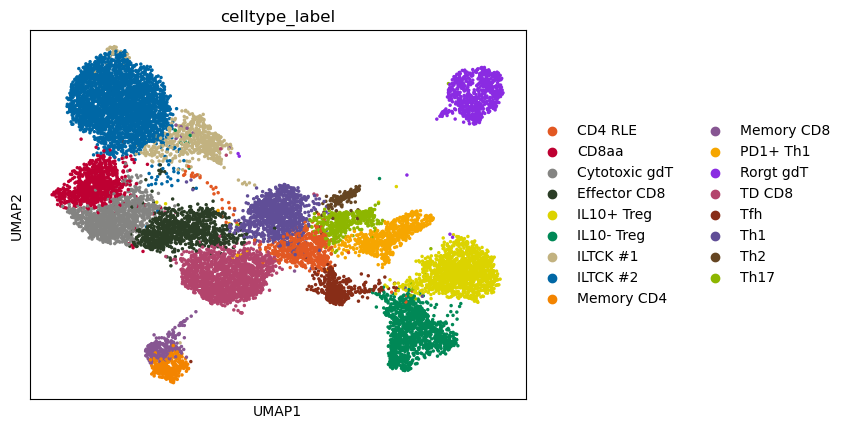

In [10]:
sc.pl.umap(adata, color='celltype_label', palette=celltype_colors, size=25)

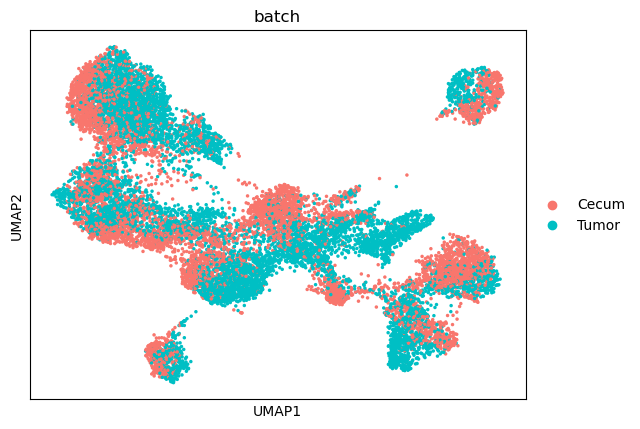

In [11]:
sc.pl.umap(adata, color='batch', palette=batch_colors_d, size=25)

In [12]:
counts = adata.layers['raw_data'].todense()
data = adata.raw.X.todense()
obs = adata.obs
umap = adata.obsm['X_umap']
gene_names = adata.var_names

In [13]:
%%R -i counts,data,obs,umap,gene_names,colors,names,batch_colors,names_batch_colors
rownames(counts) <- rownames(obs)
colnames(counts) <- gene_names
counts <- as.matrix(t(counts), sparse=TRUE)
rownames(data) <- rownames(obs)
colnames(data) <- gene_names
data <- as.matrix(t(data), sparse=TRUE)

scrna.object <- CreateSeuratObject(counts=counts, data=data)
scrna.object@meta.data <- obs
celltype_colors <- colors
names(celltype_colors) <- names
names(batch_colors) <- names_batch_colors
scrna.object$celltype_label <- factor(scrna.object$celltype_label, 
                                      levels = rev(c("Rorgt gdT", "ILTCK #1", "ILTCK #2", "CD8aa", "Cytotoxic gdT",
                                                 "Effector CD8", "TD CD8", "Memory CD8", "Memory CD4", "Th1", "Th17", "Th2",
                                                 "PD1+ Th1", "Tfh", "CD4 RLE", "IL10+ Treg", "IL10- Treg")))


`summarise()` has grouped output by 'celltype_label'. You can override using
the `.groups` argument.



Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union

The following object is masked from ‘package:GenomeInfoDb’:

    intersect

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:matrixStats’:

    count

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked f

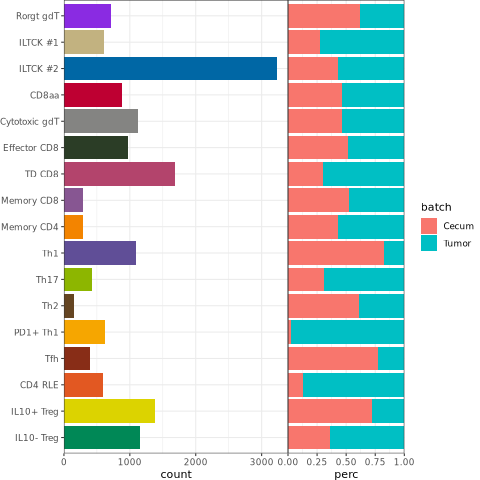

In [14]:
%%R
library(dplyr)
p1 <- ggplot(scrna.object@meta.data) + geom_bar(aes(y = celltype_label, fill=as.factor(celltype_label))) + 
    scale_fill_manual("cell type", values=celltype_colors) + theme_bw() + scale_x_continuous(expand = c(0, 0), limits = c(0, 3400)) + 
        theme(legend.position = "none", plot.margin=grid::unit(c(0,0,0,0), "mm")) + labs(y=NULL)

d2 <- scrna.object@meta.data %>% 
  group_by(celltype_label, batch) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))


p2 <- ggplot(d2, aes(y = factor(celltype_label), x = perc, fill = factor(batch))) +
  geom_bar(stat="identity") + scale_fill_manual("batch", values=batch_colors) + theme_bw() + 
    geom_col(position = position_stack(reverse = TRUE)) + 
    scale_x_continuous(expand = c(0, 0), limits = c(0, 1)) + 
    #theme(legend.position = "none", axis.text.y=element_blank(), axis.ticks.y=element_blank(), plot.margin=grid::unit(c(0,0,0,0), "mm")) + 
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), plot.margin=grid::unit(c(0,0,0,0), "mm")) + 
              labs(y=NULL)

p <- grid.arrange(p1, p2, ncol=2, 
         widths=c(6, 4))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In addition: Warning message:
`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


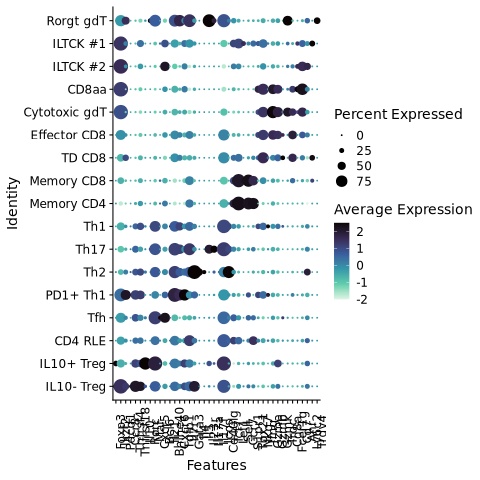

In [15]:
%%R -w 6 -h 4 -u in -r 150
p <- DotPlot(scrna.object, features=unique(c("Foxp3", "Ikzf2", "Pdcd1", "Ccr8", "Tnfrsf4", "Tnfrsf18", # T01
                        "Il10", "Rorc", "Maf", # T02
                        "Cxcr5", "Bcl6", "Il21", # T03
                        "Bhlhe40", "Cxcr6", "Tgfb1", # T04
                        "Il7r", "Gata3", "Il4", "Il5", "Il23r", # T05
                        "Il7r", "Rorc", "Il17a", "Il17f", "Il23r", "Maf", # T06
                        "Il7r", "Bhlhe40", "Icos", "Cd40lg", # T07
                        "Tcf7", "Lef1", "Sell", "Ccr7", "S1pr1", # T08
                        "Il7r", "Pdcd1", "Tbx21", "Nkg7", # T09
                        "Il7r", "Ifng", "Gzma", "Gzmb", "Gzmk", # T10
                        "Trdc", "Gzma", "Gzmb", # T11
                        "Cd8a", "Fcer1g", "Tbx21", "Gzma", "Gzmb", # T12
                        "Fcer1g", "Cd7", "Ikzf2", "Ahr", # T13
                        "Fcer1g", "Ikzf2", "Ly6c2", # T14
                        "Trdv4", "Il17a", "Rorc" # T15
                        )
                        ), group.by='celltype_label') + theme(axis.text.x = element_text(angle = 90)) +  scale_color_viridis_c(
    option = "mako",    
    direction = -1)

p

In [20]:
%%R
scatac.object <- loadArchRProject('./data/multiome_mouse_4wks_scatac')

Successfully loaded ArchRProject!

                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  ._____

Failed to query server: Transport endpoint is not connected


Overriding previous entry for celltype_label
In addition: Warning messages:
1: In system("timedatectl", intern = TRUE) :
  running command 'timedatectl' had status 1
2: The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the ArchR package.
  Please report the issue to the authors.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
3: The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the ArchR package.
  Please report the issue to the authors.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


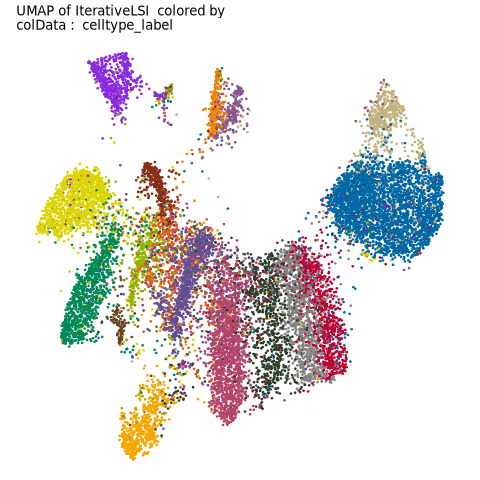

In [21]:
%%R
scatac.object <- addCellColData(scatac.object, as.character(scrna.object$celltype_label), 'celltype_label', 
                                colnames(scrna.object), force=TRUE)
p <- plotEmbedding(ArchRProj = scatac.object, colorBy = "cellColData", name = "celltype_label", 
             embedding = "UMAP", labelMeans=FALSE, size=0.6, pal=celltype_colors) + theme_void() + theme(legend.position = "none")

#ggsave(
#  plot = p,
#  filename = "outfiles/scatac_celltype_umap.pdf",
#  bg = "transparent"
#)
p

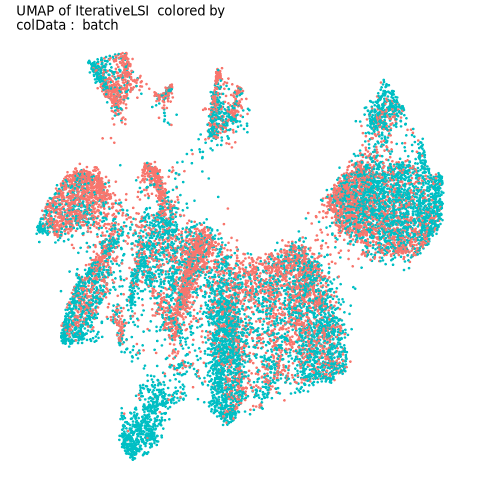

In [22]:
%%R
scatac.object <- addCellColData(scatac.object, as.character(scrna.object$batch), 'batch', 
                                colnames(scrna.object), force=TRUE)
p <- plotEmbedding(ArchRProj = scatac.object, colorBy = "cellColData", name = "batch", 
             embedding = "UMAP", labelMeans=FALSE, size=0.6, pal=batch_colors) + theme_void() + theme(legend.position = "none")

#ggsave(
#  plot = p,
#  filename = "outfiles/scatac_batch_umap.pdf",
#  bg = "transparent"
#)
p

 [1] "BATF/IRF"      "TCF7L/LEF"     "RUNX|Runt"     "IKZF/NFKB"    
 [5] "RORC/RORA"     "TBX/EOMES"     "FOSL/JUND"     "HIF1A/TCFL"   
 [9] "NFKB/RELA|Rel" "GATA"         


Identified 10 markers!
Adding Annotations..
Preparing Main Heatmap..
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.


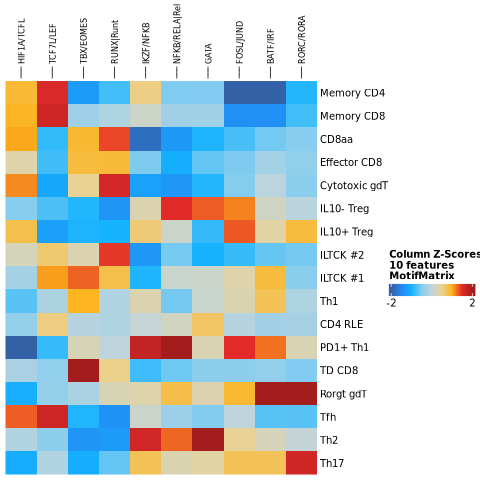

In [69]:
%%R

markersMM <- getMarkerFeatures(
    ArchRProj = scatac.object,
    useMatrix = "MotifMatrix",
    groupBy = "celltype_label",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    useSeqnames="deviations", # "z"
    testMethod = "wilcoxon")

markersMM_select <- markersMM[grepl("AC0017", rowData(markersMM)$name) | 
                                 grepl("AC0255", rowData(markersMM)$name) |
                                 grepl("AC0236", rowData(markersMM)$name) |
                                 grepl("EOMES", rowData(markersMM)$name) | 
                                 grepl("RORC", rowData(markersMM)$name) |
                                 grepl("SP2", rowData(markersMM)$name) | 
                                 grepl("FOS", rowData(markersMM)$name) | 
                                 grepl("NFKB", rowData(markersMM)$name) | 
                                 grepl("HIF1A", rowData(markersMM)$name) | 
                                 grepl("TCF7", rowData(markersMM)$name),]
rowData(markersMM_select)$name[grepl('HIF1A', rowData(markersMM_select)$name)] = 'HIF1A/TCFL' # AC0554|HIF1A/TCFL|bHLH"
rowData(markersMM_select)$name[grepl('LEF', rowData(markersMM_select)$name)] = 'TCF7L/LEF' # AC0430|TCF7L/LEF|Sox
rowData(markersMM_select)$name[grepl('EOMES', rowData(markersMM_select)$name)] = 'TBX/EOMES' # AC0635|TBX/EOMES|T-box
rowData(markersMM_select)$name[grepl('RUNX', rowData(markersMM_select)$name)] = 'RUNX|Runt' # AC0017|RUNX|Runt
rowData(markersMM_select)$name[grepl('IKZF', rowData(markersMM_select)$name)] = 'IKZF/NFKB' # AC0144|IKZF/NFKB|C2H2_ZF
rowData(markersMM_select)$name[grepl('RELA', rowData(markersMM_select)$name)] = 'NFKB/RELA|Rel' # AC0196|NFKB/RELA|Rel
rowData(markersMM_select)$name[grepl('GATA', rowData(markersMM_select)$name)] = 'GATA' # AC0255|GATA|GATA
rowData(markersMM_select)$name[grepl('AC0242', rowData(markersMM_select)$name)] = 'FOSL/JUND' # AC0242|FOSL/JUND|bZIP
rowData(markersMM_select)$name[grepl('BATF', rowData(markersMM_select)$name)] = 'BATF/IRF' # AC0236|BATF/IRF|bZIP
rowData(markersMM_select)$name[grepl('RORC', rowData(markersMM_select)$name)] = 'RORC/RORA' # AC0408|RORC/RORA|Nuclear_receptor

markersMM_select <- markersMM_select[match(c('HIF1A/TCFL', 'TCF7L/LEF', 'TBX/EOMES', 'RUNX|Runt', 'IKZF/NFKB',
                                             'NFKB/RELA|Rel', 'GATA', 'FOSL/JUND', 'BATF/IRF', 'RORC/RORA'), 
                                           rowData(markersMM_select)$name),]
markersMM_select <- markersMM_select[, match(c('Memory CD4', 'Memory CD8', 'CD8aa', 'Effector CD8', 'Cytotoxic gdT',
                                               'IL10- Treg', 'IL10+ Treg', 'ILTCK #2', 'ILTCK #1', 'Th1', 'CD4 RLE', 
                                               'PD1+ Th1', 'TD CD8', 'Rorgt gdT', 'Tfh', 'Th2', 'Th17'), colnames(markersMM_select))]
heatmapMM <- plotMarkerHeatmap(
      seMarker = markersMM_select, 
      cutOff = "FDR <= 1e-2", 
      transpose = TRUE,
      log2Norm = FALSE, returnMatrix=FALSE, clusterCols=FALSE, binaryClusterRows=FALSE
    )
heatmapMM

In [95]:
# adata_tcr = sc.read_h5ad('/data1/lesliec/sneha/workspace/CRC_analysis/outfiles/tcr_outs/tcr_rna_noLN_no_unknown_uniq_time.h5ad')
adata_tcr = sc.read_h5ad('./data/mouse_2_4_6wks_scrna.h5ad')

In [96]:
adata_tcr.obs['celltype_label'] = adata_tcr.obs['celltype_label'].values.tolist()
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='Helios+ Treg', 'celltype_label'] = 'IL10- Treg'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='Innate-like T#1', 'celltype_label'] = 'ILTCK #2'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='Innate-like T#2', 'celltype_label'] = 'ILTCK #1'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='Cytotoxic CD8', 'celltype_label'] = 'Effector CD8'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='PD1+ CD8', 'celltype_label'] = 'TD CD8'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='PD1+ CD4', 'celltype_label'] = 'PD1+ Th1'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='CCR7+ CD8', 'celltype_label'] = 'Memory CD8'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='CCR7+ CD4', 'celltype_label'] = 'Memory CD4'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='Mucosal Th1', 'celltype_label'] = 'Th1'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='Tfh-like', 'celltype_label'] = 'Tfh'
adata_tcr.obs.loc[adata_tcr.obs['celltype_label']=='newly activated CD4', 'celltype_label'] = 'CD4 RLE'

In [88]:
colors += ['#50C878', '#6495ED']
names += ['early PD1+ CD8', 'Proliferating']
celltype_tcr_colors = dict(zip(names, colors))

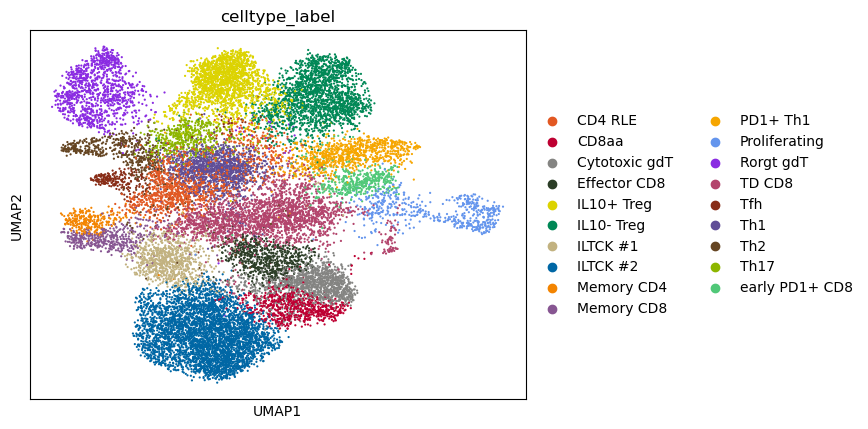

In [97]:
sc.pl.umap(adata_tcr, color='celltype_label', palette=celltype_tcr_colors, size=10)

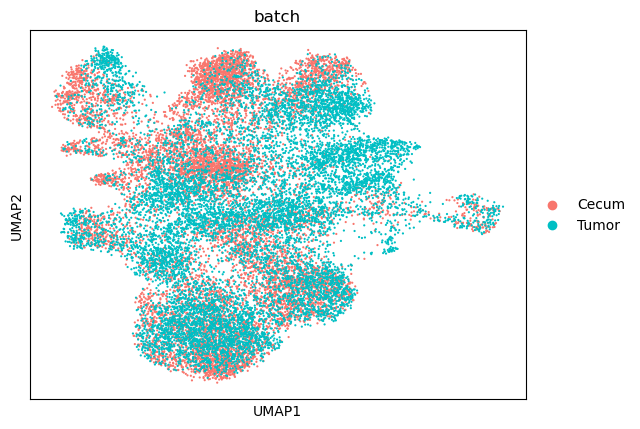

In [108]:
sc.pl.umap(adata_tcr, color='batch', palette=batch_colors, size=10)

In [114]:
data = adata_tcr.X
obs = adata_tcr.obs
umap = adata_tcr.obsm['X_umap']
gene_names = adata_tcr.var_names

In [115]:
%%R -i data,obs,umap,gene_names,colors,names
rownames(data) <- rownames(obs)
colnames(data) <- gene_names
data <- as.matrix(t(data), sparse=TRUE)

scrna.tcr.object <- CreateSeuratObject(counts=NULL, data=data)
scrna.tcr.object@meta.data <- obs
celltype_tcr_colors <- colors
names(celltype_tcr_colors) <- names
scrna.tcr.object$celltype_label <- factor(scrna.tcr.object$celltype_label, 
                                      levels = rev(c("Proliferating", "Rorgt gdT", "ILTCK #1", "ILTCK #2", "TD CD8", "early PD1+ CD8", 
                                        "Cytotoxic gdT", "CD8aa", "Effector CD8", "Memory CD8", "Memory CD4", "Th2", "Tfh", "Th1",
                                                 "Th17", "PD1+ Th1", "CD4 RLE", "IL10+ Treg", "IL10- Treg")))


/data1/lesliec/sneha/anaconda/envs/crc-env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "PhenoGraph_clusters". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


In addition: Warning message:
Cannot find the layer(s) specified 


`summarise()` has grouped output by 'timepoint_label'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'timepoint_label'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'timepoint_label'. You can override using
the `.groups` argument.


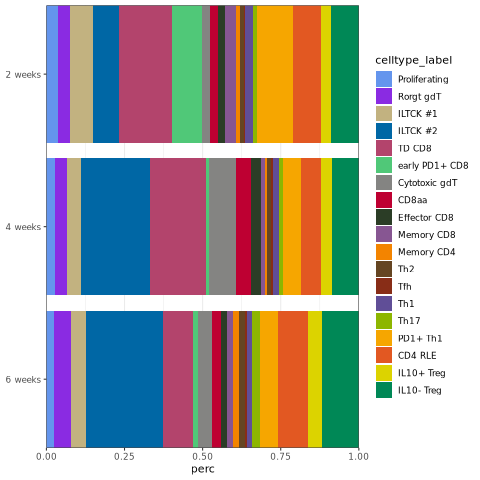

In [126]:
%%R
celltype_order_df <- data.frame(celltype_label=c("Proliferating", "Rorgt gdT", "ILTCK #1", "ILTCK #2", "TD CD8", "early PD1+ CD8", 
                                        "Cytotoxic gdT", "CD8aa", "Effector CD8", "Memory CD8", "Memory CD4", "Th2", "Tfh", "Th1",
                                                 "Th17", "PD1+ Th1", "CD4 RLE", "IL10+ Treg", "IL10- Treg"))
celltype_order_df$order <- 1:dim(celltype_order_df)[1]

d2 <- scrna.tcr.object[, scrna.tcr.object$batch=='Tumor' & scrna.tcr.object$timepoint_label=='2 weeks']@meta.data %>% 
  group_by(timepoint_label, celltype_label) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))
d2 <- merge(celltype_order_df[celltype_order_df$celltype_label %in% d2$celltype_label, ], d2, by='celltype_label')

d4 <- scrna.tcr.object[, scrna.tcr.object$batch=='Tumor' & scrna.tcr.object$timepoint_label=='4 weeks']@meta.data %>% 
  group_by(timepoint_label, celltype_label) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))
d4 <- merge(celltype_order_df, d4, by='celltype_label')

d6 <- scrna.tcr.object[, scrna.tcr.object$batch=='Tumor' & scrna.tcr.object$timepoint_label=='6 weeks']@meta.data %>% 
  group_by(timepoint_label, celltype_label) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))
d6 <- merge(celltype_order_df, d6, by='celltype_label')

d246 <- rbind(rbind(d2, d4), d6)
d246 <- d246[order(d246$order),]
levels(d246$celltype_label) <- celltype_order_df$celltype_label

d246$celltype_label <- factor(d246$celltype_label, levels=c("Proliferating", "Rorgt gdT", "ILTCK #1", "ILTCK #2", "TD CD8", "early PD1+ CD8", 
                                        "Cytotoxic gdT", "CD8aa", "Effector CD8", "Memory CD8", "Memory CD4", "Th2", "Tfh", "Th1",
                                                 "Th17", "PD1+ Th1", "CD4 RLE", "IL10+ Treg", "IL10- Treg"))

p2 <- ggplot(d246, aes(y = factor(timepoint_label), x = perc, fill = factor(celltype_label))) +
  geom_bar(stat="identity", position = position_fill(reverse = TRUE)) + scale_fill_manual("celltype_label", values=celltype_tcr_colors) + 
    theme_bw() + 
    #geom_col(position = position_stack(reverse = TRUE)) + 
    scale_x_continuous(expand = c(0, 0), limits = c(0, 1)) + 
    scale_y_discrete(limits=rev, expand=c(0,0)) +
    #theme(legend.position = "none", axis.text.y=element_blank(), axis.ticks.y=element_blank(), plot.margin=grid::unit(c(0,0,0,0), "mm")) + 
    #theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), plot.margin=grid::unit(c(0,0,0,0), "mm")) + 
              labs(y=NULL)

#ggsave(
#  plot = p2,
#  filename = "outfiles/scrna_tcr_cell_counts_tumor.pdf",
#  bg = "transparent", width = 15, height = 4
#)

p2

In [107]:
adata_tcr.obs['batch'] = adata_tcr.obs['batch'].values.tolist()
adata_tcr.obs.loc[adata_tcr.obs['batch']=='Gut', 'batch'] = 'Cecum'

In [113]:
#adata_tcr.write_h5ad('./data/mouse_2_4_6wks_scrna.h5ad')

In [125]:
%%R
d246$celltype_label <- factor(d246$celltype_label, levels=c("Proliferating", "Rorgt gdT", "ILTCK #1", "ILTCK #2", "TD CD8", "early PD1+ CD8", 
                                        "Cytotoxic gdT", "CD8aa", "Effector CD8", "Memory CD8", "Memory CD4", "Th2", "Tfh", "Th1",
                                                 "Th17", "PD1+ Th1", "CD4 RLE", "IL10+ Treg", "IL10- Treg"))

In [112]:
adata_tcr.obs['timepoint_label'] = ''
adata_tcr.obs.loc[adata_tcr.obs['timepoint']=='Group 1', 'timepoint_label'] = '2 weeks'
adata_tcr.obs.loc[adata_tcr.obs['timepoint']=='Group 2', 'timepoint_label'] = '4 weeks'
adata_tcr.obs.loc[adata_tcr.obs['timepoint']=='Group 3', 'timepoint_label'] = '6 weeks'